# SV Data Analysis

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os, sys
sys.path.insert(0, '/Users/jocelynornelasmunoz/Desktop/structural_variants/lib')
DATA_PATH='/Users/jocelynornelasmunoz/Desktop/structural_variants/data/simulated/4p_4c_coverage'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

import confusion_matrix as confmat

In [11]:
data = json.loads(open(DATA_PATH + '/test_json.json').read())

In [12]:
data.keys()

dict_keys(['fhat', 'cputime', 'iterations', 'objective', 'reconerror', 'f_true'])

In [13]:
f_hat = np.array(data['fhat'])

In [14]:
f_true = np.array(data['f_true'])

In [15]:
np.unique(f_hat)

array([0.00000000e+00, 2.09953491e-28, 2.09953491e-28, 2.09953491e-28,
       6.15173163e-28, 6.15173163e-28, 1.02039283e-27, 1.02039283e-27,
       1.42561251e-27, 1.83083218e-27, 2.23605185e-27, 2.64127152e-27,
       3.04649119e-27, 3.85693053e-27, 3.85693053e-27, 4.26215020e-27,
       5.07258955e-27, 7.50390757e-27, 2.12813764e-26, 2.29022551e-26,
       6.68971365e-12, 6.68973935e-12, 6.68973936e-12, 6.68973936e-12,
       6.68976019e-12, 6.69812249e-12, 6.69812249e-12, 1.33794319e-11,
       1.33794695e-11, 1.33794695e-11, 1.33794695e-11, 1.33795093e-11,
       1.33962193e-11, 1.33962357e-11, 1.33962357e-11, 1.33962450e-11,
       1.33962450e-11, 1.33962450e-11, 2.00691507e-11, 2.00691986e-11,
       2.00691986e-11, 2.00691986e-11, 2.00692523e-11, 2.00943479e-11,
       2.00943479e-11, 2.67589252e-11, 2.67589273e-11, 2.67589273e-11,
       2.67589915e-11, 2.67924339e-11, 2.67924598e-11, 2.67924598e-11,
       2.67924715e-11, 2.67924715e-11, 2.67924715e-11, 3.34486442e-11,
      

In [20]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(f_true, f_hat, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)

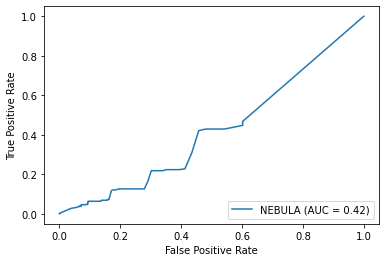

In [22]:
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='NEBULA')
display.plot()
plt.show()

In [ ]:
from confusion_matrix import heatmap, annotate_heatmap
import sklearn

con_mat = sklearn.metrics.confusion_matrix(f_true,f_hat,normalize='true')
axlabels=['SV', 'Not SV']

fig, ax = plt.subplots()
im, cbar = heatmap(con_mat, axlabels, axlabels, ax=ax,cmap = 'Blues', cbarlabel="Probability")
plt.ylabel("Truth")
plt.xlabel("Prediction")
texts = annotate_heatmap(im, valfmt="{x:.3f}")